In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# calculating wet air properties
import psychrolib
import datetime
import copy
# set international units
psychrolib.SetUnitSystem(psychrolib.SI)
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
%matplotlib inline

## Cooling Tower
from EnergyPlus EngineeringReference
### calculating outlet water temperature

In [2]:
def cal_Twb(Tdb,reHum):
    assert 0.0 <= reHum <= 1.0,'Invalid Relative Humidity'
    assert Tdb < 60,'Invalid Dry Bulb Temperature'
    Twb = psychrolib.GetTDewPointFromRelHum(Tdb, reHum)
    return Twb

In [3]:
# check the above function
cal_Twb(29,0.7)

22.972692530223053

In [4]:
# the cooling tower models from Page. 1024 Chapter 16. Simulation models - Encyclopedic reference in EngineeringReference
# these coefficients you can find from Page. 1025 
def CT_ApproachTCoeffDict(type = 'CoolTools'):
    if type == 'CoolTools':
        coeffDict = {'Coeff1':0.5204971,'Coeff2':-10.6170464,'Coeff3':10.729297,'Coeff4':-2.7498838,'Coeff5':4.7362994,
                     'Coeff6':-8.2575970,'Coeff7':1.5764094,'Coeff8':6.5111964,'Coeff9':1.5043352,'Coeff10':-3.2888529,
                     'Coeff11':0.0257786,'Coeff12':0.1824643,'Coeff13':-0.0818947,'Coeff14':-0.2150100,'Coeff15':0.0186741,
                     'Coeff16':0.0536842,'Coeff17':-0.0027097,'Coeff18':0.0011228,'Coeff19':-0.0012776,'Coeff20':0.0000760,
                     'Coeff21':1.4360009,'Coeff22':-0.5198696,'Coeff23':0.1173396,'Coeff24':1.5049281,'Coeff25':-0.1358989,
                     'Coeff26':-0.1525776,'Coeff27':-0.0533844,'Coeff28':0.0049329,'Coeff29':-0.0079626,'Coeff30':0.0002226,
                     'Coeff31':-0.0543952,'Coeff32':0.0047427,'Coeff33':-0.0185855,'Coeff34':0.0011566,'Coeff35':0.0008074}
    elif type == 'YorkCalc':
        coeffDict = {'Coeff1':-0.359741205,'Coeff2':-0.055053608,'Coeff3':0.0023850432,'Coeff4':0.173926877,
                     'Coeff5':-0.0248473764,'Coeff6':0.00048430224,'Coeff7':-0.005589849456,'Coeff8':0.000577079712,
                     'Coeff9':-0.00001342427256,'Coeff10':2.84765801111111,'Coeff11':-0.121765149,'Coeff12':0.0014599242,
                     'Coeff13':1.680428651,'Coeff14':-0.0166920786,'Coeff15':-0.0007190532,'Coeff16':-0.025485194448,
                     'Coeff17':0.0000487491696,'Coeff18':0.00002719234152,'Coeff19':-0.0653766255555556,
                     'Coeff20':-0.002278167,'Coeff21':0.0002500254,'Coeff22':-0.0910565458,'Coeff23':0.00318176316,
                     'Coeff24':0.000038621771,'Coeff25':-0.0034285382352,'Coeff26':0.00000856589904,'Coeff27':-0.000001516821552}
    return coeffDict

In [5]:
# calculate temperature of cooling water leaving cooling towers - in the way of loop
# FRair = the ratio of real-time fan frequency(Hz) to 50
def CT_T_outwater(coeffDict,FRair,FRwater,Tr,Twb):
    assert 0 <= FRair <= 1,'Invalid FRair'
    assert 0 <= FRwater <= 1,'Invalid FRwater'
    # assert -1.0 <= Twb <= 26.7,'wet bulb temperature is not in the valid range'
    approachT = coeffDict['Coeff1'] + coeffDict['Coeff2'] * FRair + coeffDict['Coeff3'] * (FRair ** 2) + \
                coeffDict['Coeff4'] * (FRair ** 3) + coeffDict['Coeff5'] * FRwater + \
                coeffDict['Coeff6'] * FRair * FRwater + coeffDict['Coeff7'] * (FRair ** 2) * FRwater + \
                coeffDict['Coeff8'] * (FRwater ** 2) + coeffDict['Coeff9'] * FRair * (FRwater ** 2) + \
                coeffDict['Coeff10'] * (FRwater ** 3) + coeffDict['Coeff11'] * Twb + coeffDict['Coeff12'] * FRair * Twb + \
                coeffDict['Coeff13'] * (FRair ** 2) * Twb + coeffDict['Coeff14'] * FRwater * Twb + \
                coeffDict['Coeff15'] * FRair * FRwater * Twb + coeffDict['Coeff16'] * (FRwater ** 2) * Twb + \
                coeffDict['Coeff17'] * (Twb ** 2) + coeffDict['Coeff18'] * FRair * (Twb ** 2)+ \
                coeffDict['Coeff19'] * FRwater * (Twb ** 2) + coeffDict['Coeff20'] * (Twb ** 3) + coeffDict['Coeff21'] * Tr + \
                coeffDict['Coeff22'] * FRair * Tr + coeffDict['Coeff23'] * (FRair ** 2) * Tr + \
                coeffDict['Coeff24'] * FRwater * Tr + coeffDict['Coeff25'] * FRair * FRwater * Tr + \
                coeffDict['Coeff26'] * (FRwater ** 2) * Tr + coeffDict['Coeff27'] * Twb * Tr + \
                coeffDict['Coeff28'] * FRair * Twb * Tr + coeffDict['Coeff29'] * FRwater * Twb * Tr + \
                coeffDict['Coeff30'] * (Twb ** 2) * Tr + coeffDict['Coeff31'] * (Tr ** 2) + coeffDict['Coeff32'] * FRair * (Tr ** 2) + \
                coeffDict['Coeff33'] * FRwater * (Tr ** 2) + coeffDict['Coeff34'] * Twb * (Tr ** 2) + coeffDict['Coeff35'] * (Tr ** 2)
    # assert 1.1 <= approachT <= 11.1,"approachT not in the valid range"
    T_outwater = abs(approachT) + Twb
    return T_outwater

In [6]:
# In order to simplify the process, I use loop to find the most appropriate candidate temperature
# Alert: this not ensures convergence
def cal_T_outwater(FRair,FRwater,T_inwater,Tdb,reHum):
    coeffDict = CT_ApproachTCoeffDict(type = 'CoolTools')
    Twb = cal_Twb(Tdb,reHum)
    res_lis = []
    
    for T_test in np.arange(0,T_inwater +0.1,0.1):
        # T_outwater should be less than T_inwater
        T_outwater = CT_T_outwater(coeffDict,FRair,FRwater,T_inwater - T_test,Twb)
        res_lis.append(abs(T_test - T_outwater))
    
    min_num = res_lis[0]
    min_index = 0
    for i in range(len(res_lis)):
        if res_lis[i] < min_num:
            min_num = res_lis[i]
            min_index = i
            
    # assert 1.1 <= abs(T_inwater - T_outwater) <= 11.1,'delta of cooling supply and return water temperature needs fall in the valid range'
    #print(min_num,'minimum residuals')
            
    T_outwater = 0.1 * min_index
    return float(format(T_outwater,'.1f'))
  

In [7]:
# test 
cal_T_outwater(FRair = 0.9,FRwater = 0.8,T_inwater = 30,Tdb = 24,reHum = 0.6)

22.2

### calcluating fan power

In [8]:
# coz the cubic relationship between power and frequency
# the coefficients is based on a real model, you can change the coefficents based on your reality
def CT_Power_coeff():
    coeff = {'coeff1': -9.436,'coeff2':0.7328, 'coeff3':-0.01375, 'coeff4':0.0002145}
    return coeff

def cal_CT_FanPower(f):
    coeff = CT_Power_coeff()
    # we set the reasonable frequency range is 30-50Hz based on reality and safety issue
    assert 30 <= f <= 50,"invalid frequency"
    # unit ： KWH
    FanPower = coeff['coeff1'] + coeff['coeff2'] * f + coeff['coeff3'] * (f ** 2) + coeff['coeff4'] * (f ** 3)
    return FanPower
    

In [9]:
# test
cal_CT_FanPower(50)

19.6415

## Cooling Water Pump

In [10]:
# In our system, we have two kinds of water power, with big and small capacities
# In our case, go for simplicity, the water pump frequency is fixed (50Hz), so the water pump fan is fixed ideally
def CWP_Big_Power(f=50):
    power = 19 # unit KW
    return power

def CWP_Small_Power(f=50):
    power = 8 # unit KW
    return power

In [11]:
# CWP_Big_Q   <==> CWP_Big_Power
# CWP_Small_Q <==> CWP_Small_Power
# When presuming the pipe resistance is unchanged, other things are perfectly, the real-time water flow is proportion to frequency
# Big Water pump has two, and small water pump has one
# the maximum wateflow is 3000 m³/h
def CWP_Big_Q(f=50):
    Q = 1100 # unit m³/h
    return Q

def CWP_Small_Q(f=50):
    Q = 800 # unit m³/h
    return Q

## Chilled Water Pump

In [12]:
# the part of chilled water pumps is the same as that of cooling water pumps
def CHWP_Big_Power(f=50):
    power = 23 # unit KW
    return power

def CHWP_Small_Power(f=50):
    power = 10.5 # unit KW
    return power

In [13]:
# wanna explain the relationship between cooling water pumps and chilled water pumps
# one big cooling water pump matches one big chilled water pump
# one small cooling water pump matches one small chilled water pump
# based on that, there are two big chilled water pumps and single small chilled water pump
# When one big chilled water pump is on, there must have a big cooling water pump under operation 
def CHWP_Big_Q(f=50):
    Q = 450 # unit m³/h
    return Q

def CHWP_Small_Q(f=50):
    Q = 300 # unit m³/h
    return Q

## Chiller  (one kind has smaller capacity, one has larger capacity)

### The Chiller with smaller capacity
**small chiller matches smaller cooling/chilled water pump**

In [15]:
# the Empirical Formula to obtain COP of the chiller with smaller capacity
# the formula is based on 14.3.9 and 14.3.10 EIR model, which is widely used in various papers
# EnergyPlus supply official .idf files where you can find different kinds of chillers in case of the lack of chiller model to hand
def coeffDict_CapFTemp_small():
    coeff_CapFTemp = {'coeff1':0.4742518,'coeff2':-0.05109937,'coeff3':-0.002845323,
                      'coeff4':0.0857997,'coeff5':-0.003404799,'coeff6':0.005625321}
    return coeff_CapFTemp

def coeffDict_EIRFTemp_small():
    coeff_EIRFTemp = {'coeff1':0.2950574,'coeff2':-0.1036684,'coeff3':-0.004169567,
                      'coeff4':0.1256790,'coeff5':-0.004004203,'coeff6':0.006718687}
    return coeff_EIRFTemp

def coeffDict_EIRFPLR_small():
    coeff_EIRFPLR = {'coeff1':0.2374010,'coeff2':-0.1796745,'coeff3':0.9441507}
    return coeff_EIRFPLR

# Q_part: partial load
# Q_ref: nominal capacity marked on nameplate
# COP_ref: nominal COP marked on nameplate
# T_cwl: the temperature of chilled supply water
# T_conde: the temperature of cooling supply water (generated by cooling tower)
def cal_chiller_COP_small(T_cwl,T_conde,Q_part,Q_ref,COP_ref):
    # York YT 1368kW/7.35COP/VSD (this is the make and model of the smaller chiller, you can change whatever you want)
    PLR = Q_part / Q_ref
    coeff_CapFTemp = coeffDict_CapFTemp_small()
    coeff_EIRFTemp = coeffDict_EIRFTemp_small()
    coeff_EIRFPLR = coeffDict_EIRFPLR_small()
    
    ChillerCapFTemp = coeff_CapFTemp['coeff1'] + coeff_CapFTemp['coeff2'] * T_cwl + coeff_CapFTemp['coeff3'] * (T_cwl ** 2) + \
                      coeff_CapFTemp['coeff4'] * T_conde + coeff_CapFTemp['coeff5'] * (T_conde ** 2) + \
                      coeff_CapFTemp['coeff6'] * T_cwl * T_conde
    #Q_ref_spec = ChillerCapFTemp * Q_ref
    
    ChillerEIRTemp = coeff_EIRFTemp['coeff1'] + coeff_EIRFTemp['coeff2'] * T_cwl + coeff_EIRFTemp['coeff3'] * (T_cwl ** 2) + \
                     coeff_EIRFTemp['coeff4'] * T_conde + coeff_EIRFTemp['coeff5'] * (T_conde ** 2) + \
                     coeff_EIRFTemp['coeff6'] * T_cwl * T_conde
    
    #COP_ref_spec = (ChillerEIRTemp * (COP_ref ** -1)) ** -1
    
    ChillerEIRFPLR = coeff_EIRFPLR['coeff1'] + coeff_EIRFPLR['coeff2'] * PLR + coeff_EIRFPLR['coeff3'] * (PLR ** 2)
    P = (ChillerCapFTemp * ChillerEIRFPLR * ChillerEIRFPLR * Q_ref) / COP_ref
    
    COP = Q_part / P
    
    Result = {'COP':abs(COP),'P':abs(P)}
    
    return Result
    

In [16]:
cal_chiller_COP_small(T_cwl=7,T_conde=21,Q_part=1363,Q_ref=1363,COP_ref=7.35)

{'COP': 6.630672085602478, 'P': 205.55985613578338}

### The Chiller with larger capacity
**larger chiller matches larger chilled/cooling water pump**

In [18]:
# same with the chiller with smaller capacity
def coeffDict_CapFTemp_big():
    coeff_CapFTemp = {'coeff1':0.2210324,'coeff2':-0.02752320,'coeff3':0.0004903763,
                      'coeff4':0.07337449,'coeff5':-0.001919426,'coeff6':0.001935659}
    return coeff_CapFTemp

def coeffDict_EIRFTemp_big():
    coeff_EIRFTemp = {'coeff1':0.2267558,'coeff2':-0.07615857,'coeff3':0.002140583,
                      'coeff4':0.07088812,'coeff5':-0.001124968,'coeff6':0.0006089843}
    return coeff_EIRFTemp

def coeffDict_EIRFPLR_big():
    coeff_EIRFPLR = {'coeff1':0.3023576,'coeff2':-0.02893592,'coeff3':0.7262269}
    return coeff_EIRFPLR

# Q_part: partial load
# Q_ref: nominal capacity marked on nameplate
# COP_ref: nominal COP marked on nameplate
# T_cwl: the temperature of chilled supply water
# T_conde: the temperature of cooling supply water (generated by cooling tower)
def cal_chiller_COP_big(T_cwl,T_conde,Q_part,Q_ref,COP_ref):
    # York YK 4396kW/6.63COP/
    PLR = Q_part / Q_ref
    coeff_CapFTemp = coeffDict_CapFTemp_big()
    coeff_EIRFTemp = coeffDict_EIRFTemp_big()
    coeff_EIRFPLR = coeffDict_EIRFPLR_big()
    
    ChillerCapFTemp = coeff_CapFTemp['coeff1'] + coeff_CapFTemp['coeff2'] * T_cwl + coeff_CapFTemp['coeff3'] * (T_cwl ** 2) + \
                      coeff_CapFTemp['coeff4'] * T_conde + coeff_CapFTemp['coeff5'] * (T_conde ** 2) + \
                      coeff_CapFTemp['coeff6'] * T_cwl * T_conde
    Q_ref_spec = ChillerCapFTemp * Q_ref
    #plr = CL / (nominal_cap * cap_factor)
    #PLR = Q_part / (COP_ref * ChillerCapFTemp)
    
    ChillerEIRTemp = coeff_EIRFTemp['coeff1'] + coeff_EIRFTemp['coeff2'] * T_cwl + coeff_EIRFTemp['coeff3'] * (T_cwl ** 2) + \
                     coeff_EIRFTemp['coeff4'] * T_conde + coeff_EIRFTemp['coeff5'] * (T_conde ** 2) + \
                     coeff_EIRFTemp['coeff6'] * T_cwl * T_conde
    
    COP_ref_spec = (ChillerEIRTemp * (COP_ref ** -1)) ** -1
    #p = nominal_power * cap_factor * eir_t_factor * eir_plr_factor
    
    ChillerEIRFPLR = coeff_EIRFPLR['coeff1'] + coeff_EIRFPLR['coeff2'] * PLR + coeff_EIRFPLR['coeff3'] * (PLR ** 2)
    P = (ChillerCapFTemp * ChillerEIRFPLR * ChillerEIRFPLR * Q_ref) / COP_ref
    #P = (Q_ref/COP_ref) * ChillerCapFTemp * ChillerEIRTemp * ChillerEIRFPLR
    
    COP = Q_part / P
    
    Result = {'COP':abs(COP),'P':abs(P)}
    
    #return Result
    return Result
    

In [19]:
# test
cal_chiller_COP_big(T_cwl = 7,T_conde = 20.9,Q_part = 520,Q_ref = 3868,COP_ref = 6.33)

{'COP': 8.503912042045894, 'P': 61.148327667191744}

## cooling load reloading...
**the unit of cooling load is KW**

In [20]:
df_load = pd.read_csv(r'CoolingLoad.csv')
cal_load = copy.deepcopy(df_load['cooling load'].values[::4])
cal_load[cal_load<100] = 0

## weather reloading...

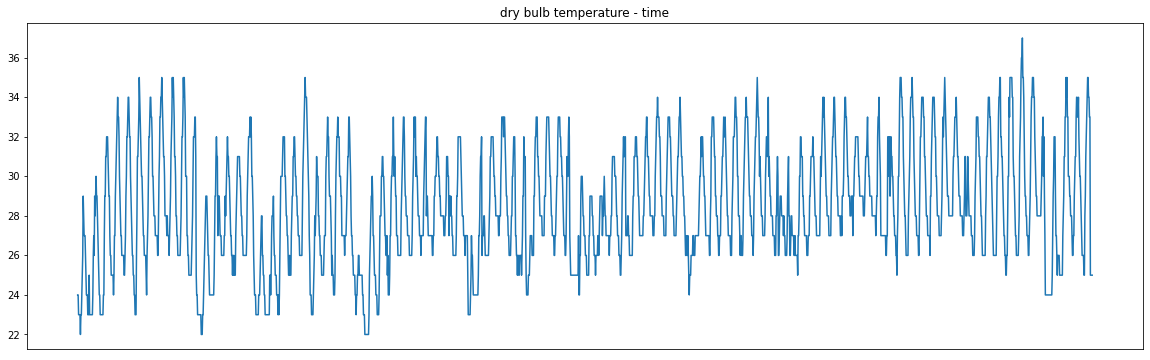

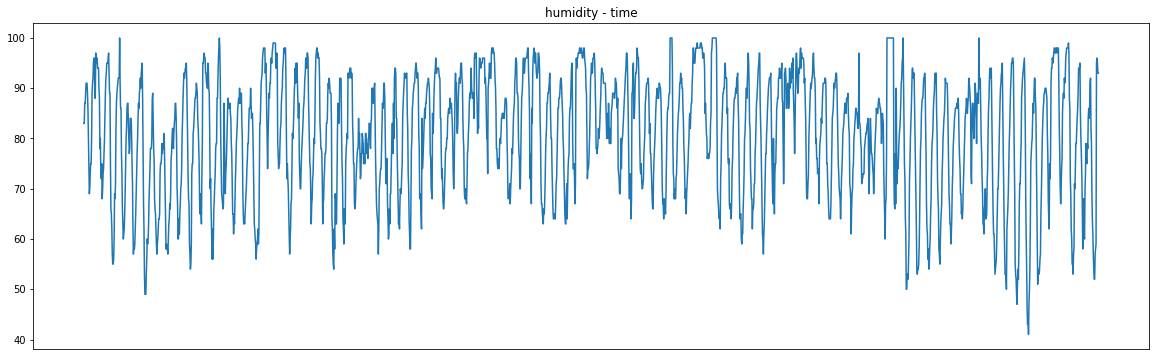

In [21]:
df_weather = pd.read_csv(r'Weather.csv')
time = df_weather['DateTime'].values[::4]
tout = df_weather['tout'].values[::4]

plt.figure(figsize=(20,6))
plt.plot(time,tout)
plt.xticks([])
plt.title('dry bulb temperature - time')
plt.show()

hout = df_weather['hout'].values[::4]
plt.figure(figsize=(20,6))
plt.plot(time,hout)
plt.xticks([])
plt.title('humidity - time')
plt.show()

## subfunction

### All nominal parameters we need

In [23]:
def equipment_parameters(): 
    
    chiller_big_parameters = {'Reference Capacity KW':2799,
                              'Reference COP':6.40,
                              'Reference Leaving Chilled Water Temperature':6.67,
                              'Reference Entering Condenser Fluid Temperature':26.11,
                              'Reference Chilled Water Flow Rate m3/s':0.09893,
                              'Reference Condenser Fluid Flow Rate':0.13761}

    chiller_small_parameters = {'Reference Capacity KW':1723,
                                'Reference COP':8.32,
                                'Reference Leaving Chilled Water Temperature':6.11,
                                'Reference Entering Condenser Fluid Temperature':12.78,
                                'Reference Chilled Water Flow Rate m3/s':0.04757,
                                'Reference Condenser Fluid Flow Rate':0.06934}

    cooling_tower_parameters = {'Reference Water Flow m3/h':150,
                               'Reference Fan Frequency Hz':50,
                               'Number of Cooling Towers':20}
    
    equipment_parameters = {'chiller_big':chiller_big_parameters,
                           'chiller_small':chiller_small_parameters,
                           'cooling_tower':cooling_tower_parameters}
    
    return equipment_parameters

In [24]:
# test
equipment_parameters()['cooling_tower']

{'Reference Water Flow m3/h': 150,
 'Reference Fan Frequency Hz': 50,
 'Number of Cooling Towers': 20}

### determine chiller, chilled/cooling water pump operation, and then determine power of water pumps and water flow

In [26]:
# determine chiller operation
def cal_chillers_condition(load):
    
    # default is all chillers are down
    # unit:KW
    if load <= 100:
        chillers_condition = {'chiller_big_num':0,'chiller_small_num':0}    
    elif 0 < load <= 1720:
        chillers_condition = {'chiller_big_num':0,'chiller_small_num':1}        
    elif 1720 < load <= 2780:
        chillers_condition = {'chiller_big_num':1,'chiller_small_num':0}  
    elif 2780 < load <= 4500:
        chillers_condition = {'chiller_big_num':1,'chiller_small_num':1}    
    elif 4500 < load <= 5560:
        chillers_condition = {'chiller_big_num':2,'chiller_small_num':0}
    elif 5560 < load <= 7280:
        chillers_condition = {'chiller_big_num':2,'chiller_small_num':1}    
    elif 7280 < load <= 8340:
        chillers_condition = {'chiller_big_num':3,'chiller_small_num':0}   
    else:
        chillers_condition = {'chiller_big_num':3,'chiller_small_num':1}
    
    #print('larger chiller',chillers_condition['chiller_big_num'],'under operation，smaller chiller',chillers_condition['chiller_small_num'],'uder operation')
    
    return chillers_condition

In [27]:
# determine water pump operation
def cal_pumps_condition(chillers_condition):
    pumps_condition = {'chilled_cooling_pump_big':0,'chilled_cooling_pump_small':0}
    
    if chillers_condition == {'chiller_big_num':0,'chiller_small_num':1}:
        pumps_condition = {'chilled_cooling_pump_big':0,'chilled_cooling_pump_small':1}
        
    elif chillers_condition == {'chiller_big_num':1,'chiller_small_num':0}:
        pumps_condition = {'chilled_cooling_pump_big':1,'chilled_cooling_pump_small':0}
        
    elif chillers_condition == {'chiller_big_num':1,'chiller_small_num':1}:
        pumps_condition = {'chilled_cooling_pump_big':1,'chilled_cooling_pump_small':1}
        
    elif chillers_condition == {'chiller_big_num':2,'chiller_small_num':0}:
        pumps_condition = {'chilled_cooling_pump_big':2,'chilled_cooling_pump_small':0}
        
    elif chillers_condition == {'chiller_big_num':2,'chiller_small_num':1}:
        pumps_condition = {'chilled_cooling_pump_big':2,'chilled_cooling_pump_small':1}
        
    elif chillers_condition == {'chiller_big_num':3,'chiller_small_num':0}:
        pumps_condition = {'chilled_cooling_pump_big':3,'chilled_cooling_pump_small':0}
        
    elif chillers_condition == {'chiller_big_num':3,'chiller_small_num':1}:
        pumps_condition = {'chilled_cooling_pump_big':3,'chilled_cooling_pump_small':1}
        
    return pumps_condition

# calculate power (electricity consumption) of water pumps
def cal_pumps_power(pumps_condition):
    # for cooling water pumps
    CWP_small = CWP_Small_Power() * pumps_condition['chilled_cooling_pump_small']
    CWP_big = CWP_Big_Power() * pumps_condition['chilled_cooling_pump_big']
    # for chilled water pumps
    CHWP_small = CHWP_Small_Power() * pumps_condition['chilled_cooling_pump_small']
    CHWP_big = CHWP_Big_Power() * pumps_condition['chilled_cooling_pump_big']
    Pumps_all = CWP_small + CWP_big + CHWP_small + CHWP_big
    return Pumps_all

# calculate the total water flow in cooling water loop and chilled water loop
def cal_Qchwcw(pumps_condition):
    # chilled/cooling water flow unit m³/h
    Q_condition = {'Q_chilled':CHWP_Small_Q() * pumps_condition['chilled_cooling_pump_small'] + \
                               CHWP_Big_Q() * pumps_condition['chilled_cooling_pump_big'],
                   'Q_cooling':CWP_Small_Q() * pumps_condition['chilled_cooling_pump_small'] + \
                               CWP_Big_Q() * pumps_condition['chilled_cooling_pump_big']}
    return Q_condition

# calculate the chilled supply water temperature
# theoretically, the chillers have capacity of meeting the setpoint temperature of chilled supply water
def cal_Tchs(load,chillers_condition,pumps_condition,T_chsset,Tchr=12):
    # when chillers are on
    if 0 <= load <= 12967:
        Tchs = 7
    elif load < 0:
        print('invalid load, value much be greater than zero')
        Tchs = 7 
    else:
        Q_chilled = cal_Qchwcw(pumps_condition)['Q_chilled']        
        Tchs = -(12967 * 3600)/(4.2 * 1000 * Q_chilled) + Tr
        if Tchs < Tchsset: # if Tchs is less than 7, which means operating chillers are able to generate 7 Celsius water
            Tchs = Tchsset
    return Tchs
        
        

In [28]:
# test
chillers_condition = cal_chillers_condition(4000)
print(chillers_condition)
pumps_condition = cal_pumps_condition(chillers_condition)
print(pumps_condition)
power_pumps = cal_pumps_power(pumps_condition)
print(power_pumps)
Q_condition = cal_Qchwcw(pumps_condition)
print(Q_condition)

{'chiller_big_num': 1, 'chiller_small_num': 1}
{'chilled_cooling_pump_big': 1, 'chilled_cooling_pump_small': 1}
60.5
{'Q_chilled': 750, 'Q_cooling': 1900}


## Q-Learning

### initialization

In [29]:
def Q_table_ini():
    # presume the maximun load is 7000 KW or so
    # allocate part of load to chiller will smaller capacity
    Q_table = pd.DataFrame(columns=[np.arange(0,1.05,0.05)],index=[np.arange(0,1.05,0.05)])
    Q_table.fillna(0,inplace = True)
    return Q_table

In [30]:
# test above function: randomized experiments
# Q_table: the column is ratio of part load of smaller chiller, the row is ratio of part load of larger chiller
Q_table = Q_table_ini()
for i in tqdm(range(100)):
    Q_table.loc[tuple((random.choice(np.arange(0,1.05,0.05)),)),
                tuple((random.choice(np.arange(0,1.05,0.05)),))] = random.choice(np.arange(0,100,1))

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3583.53it/s]


In [31]:
def Q_para_ini():
    # parameters for reward update
    para_dict = {'alpha':0.9,
                 'gamma':0.01,
                 'epsilon':0.1}
    return para_dict

In [32]:
Q_para_ini()

{'alpha': 0.9, 'gamma': 0.01, 'epsilon': 0.1}

### update value in Q table

In [33]:
def update_Q_table(value_old,reward,value_max,a,y):
    value_new = value_old + a * (reward + y * value_max - value_old)
    return value_new

In [34]:
# test
update_Q_table(2,6,0,0.9,0.01)

5.6

### classification for load allocation

In [35]:
def class_chillers_condition(load):
    chillers_condition = cal_chillers_condition(load)
    if (chillers_condition['chiller_big_num'] == 0 or
        chillers_condition['chiller_small_num'] == 0):
        class_type = 'one' # either smaller chiller or larger chiller under operation
        
    else:
        class_type = 'two' # two kinds of chillers will be operating
        
    return class_type

In [36]:
# test
class_chillers_condition(4000)

'two'

### discretization ratio of part load

In [37]:
def cal_discrete_load(load):
    load_max_set = 7000 # unit KW
    assert load <= load_max_set,'invalid real-time load, greater than upper limit'
    plr = load / load_max_set
    # print('current part load rate:',plr)
    for value in np.arange(0,1.05,0.05):
        if value >= plr:
            discrete_load = value
            break
    return discrete_load

In [38]:
# test
cal_discrete_load(400)

0.1

### when no need to allocate load, the following function is used to allocate load between two chiller of same make and model

In [39]:
# load allocation
def cal_chillers_load_sharing(load,chillers_condition):
    chiller_big_parameters = equipment_parameters()['chiller_big']
    chiller_small_parameters = equipment_parameters()['chiller_small']
    
    if chillers_condition['chiller_big_num'] != 0 or chillers_condition['chiller_small_num'] != 0:
        PL_big = ((load * chiller_big_parameters['Reference Capacity KW']) / 
                  (chillers_condition['chiller_big_num'] * chiller_big_parameters['Reference Capacity KW'] +
                   chillers_condition['chiller_small_num'] * chiller_small_parameters['Reference Capacity KW']))
        #print('PL-larger chiller',PL_big)

        PL_small = ((load * chiller_small_parameters['Reference Capacity KW']) / 
                    (chillers_condition['chiller_big_num'] * chiller_big_parameters['Reference Capacity KW'] +
                     chillers_condition['chiller_small_num'] * chiller_small_parameters['Reference Capacity KW']))
        #print('PL-smaller chiller',PL_small)
    else:
        PL_big = 0
        PL_small = 0
    
    Result = {'PL_big':PL_big,'PL_small':PL_small} # unit: KW
    return Result

In [40]:
chillers_condition = cal_chillers_condition(400)
cal_chillers_load_sharing(400,chillers_condition)

{'PL_big': 649.7968659315148, 'PL_small': 400.0}

### This part is used in decoupling the system
**presume the fixed temperature of chilled water entering chillers, calculate the temperature of chilled water leaving chiller**

In [41]:
def cal_Tchs(load,chillers_load_sharing,tchr = 12):
    chillers_condition = cal_chillers_condition(load)
    # chillers_load_sharing = cal_chillers_load_sharing(load,chillers_condition)
    pumps_condition = cal_pumps_condition(chillers_condition)
    Q_condition = cal_Qchwcw(pumps_condition)
    # calculate the temperature of chilled return water for two kinds of chillers
    tchss = tchr - (chillers_load_sharing['PL_small']*3600)/(CHWP_Small_Q()*1000*4.2)
    tchsb = tchr - (chillers_load_sharing['PL_big']*3600)/(CHWP_Big_Q()*1000*4.2)
    tchs = (pumps_condition['chilled_cooling_pump_big']*CHWP_Big_Q()*tchsb + 
            pumps_condition['chilled_cooling_pump_small']*CHWP_Small_Q()*tchss) / (pumps_condition['chilled_cooling_pump_big']*CHWP_Big_Q() +
                                                                                   pumps_condition['chilled_cooling_pump_small']*CHWP_Small_Q())
    Result = {'tchss':tchss,'tchsb':tchsb,'tchs':tchs}
    return Result

In [42]:
# test
chillers_condition = cal_chillers_condition(4000)
chillers_load_sharing = cal_chillers_load_sharing(4000,chillers_condition)
cal_Tchs(4000,chillers_load_sharing)

{'tchss': 7.645416061161307,
 'tchsb': 7.284008340178177,
 'tchs': 7.42857142857143}

### calculate the total chiller COP  under some circumstance

In [43]:
# calculate the power (electricity consumption) of chillers
# presume the fixed temperature of the cooling water entering chillers
# but the temperature of the chilled water leaving chillers is unknown
# chillers_condition: the number of chillers under operation
# chillers_load_sharing: load allocation
# T_cwl: the temperaute of chilled water leaving chillers
# T_conde: the temperature of cooling water entering chillers
def cal_chillers_powers(chillers_condition,chillers_load_sharing,T_cwl,T_conde):
    # load the parameters of chillers
    chiller_big_parameters = equipment_parameters()['chiller_big']
    chiller_small_parameters = equipment_parameters()['chiller_small']
    
    power_chillers_big = (chillers_condition['chiller_big_num'] * 
                          cal_chiller_COP_big(T_cwl['tchsb'],T_conde,chillers_load_sharing['PL_big'],
                                              chiller_big_parameters['Reference Capacity KW'],
                                              chiller_big_parameters['Reference COP'])['P'])
                     
    power_chillers_small = (chillers_condition['chiller_small_num'] * 
                            cal_chiller_COP_small(T_cwl['tchss'],T_conde,chillers_load_sharing['PL_small'],
                                                  chiller_small_parameters['Reference Capacity KW'],
                                                  chiller_small_parameters['Reference COP'])['P'])
    
    # total COP
    COP_all = (chillers_load_sharing['PL_small'] * chillers_condition['chiller_small_num'] + 
               chillers_load_sharing['PL_big'] * chillers_condition['chiller_big_num']) / (power_chillers_big + 
                                                                                           power_chillers_small)
        
    Result = {'power_chillers_big':power_chillers_big,
              'power_chillers_small':power_chillers_small,
              'power_chillers_all':power_chillers_big + power_chillers_small,
              'COP_all':COP_all}
    
    return Result

In [44]:
chillers_condition = cal_chillers_condition(4000)
chillers_load_sharing = cal_chillers_load_sharing(4000,chillers_condition)
T_cwl = cal_Tchs(4000,chillers_load_sharing)
cal_chillers_powers(chillers_condition,chillers_load_sharing,T_cwl,25)
print(cal_Tchs(4000,chillers_load_sharing))

{'tchss': 7.645416061161307, 'tchsb': 7.284008340178177, 'tchs': 7.42857142857143}


### calculate the temperature of cooling water entering cooling tower (decoupling)

In [45]:
# Tcws_lis: the initialization for calulation of temperature of cooling water leaving cooling tower
# load: cooling load
# Q_cooling: the waterflow in cooling water loop
# num_ct: the number of cooling towers under operation
# f_ct: the real-time frequency of fan in cooling towers
# tout: dry bulb temperature of ambient air
# hout: humidity of ambient air
# Tchs: temperature of chilled water leaving chillers
def cal_Tcws(Tcws_lis,load,Q_cooling,num_ct,f_ct,tout,
             hout,chillers_condition,chillers_load_sharing,Tchs):
    # load the parameters of coolings
    cooling_tower_parameters = equipment_parameters()['cooling_tower']
    
    inter_num = 0 # initialization for iteration
    Tcws_final = 0 # in case no result finally
    while inter_num < 100: # set the maximum of iteration
        # calculate Temperature of cooling water leaving cooling tower from the perspective of cooling tower
        Tcwr = cal_T_outwater(FRair = f_ct/50,
                              FRwater = Q_cooling/(num_ct * cooling_tower_parameters['Reference Water Flow m3/h']),
                              T_inwater = Tcws_lis[inter_num],Tdb = tout,reHum = (hout/100))
        
        # calculate the power (electricity consumption) of chillers
        power_chillers_all = cal_chillers_powers(chillers_condition,chillers_load_sharing,Tchs,Tcwr)['power_chillers_all']
        
        # calculate Temperature of cooling water leaving cooling tower from the perspective of chillers
        # Temp of cooling water leaving cooling tower == Temp of cooling water entering chillers
        # Given the perfect insulation
        Tcws = ((load + power_chillers_all) * 3600)/(4.2 * 1000 * Q_cooling) + Tcwr                    
        if abs(Tcws_lis[inter_num] - Tcws) < 0.05:
            Tcws_final = Tcws
            Tcwr_final = Tcwr
            break
        Tcws_lis.append(Tcws)
        inter_num += 1

    if Tcws_final == 0: # means cannot converge
        # from two perspectives (chiller and cooling tower), much difference between two kinds of Temperature
        # failure of decoupling
        Tcws_final = Tcws # use the result of the last time
        Tcwr_final = Tcwr
        
    Result = {'Tcws':Tcws_final,'Tcwr':Tcwr_final}
    # print('Celsius|temperature water entering tower',Tcws_final,'temperature water leaving tower:',Tcwr_final)
    
    return Result

In [46]:
chillers_condition = cal_chillers_condition(4000)
chillers_load_sharing = cal_chillers_load_sharing(4000,chillers_condition)
T_cwl = cal_Tchs(4000,chillers_load_sharing)
cal_chillers_powers(chillers_condition,chillers_load_sharing,T_cwl,25)
cal_Tcws([30],4000,Q_condition['Q_cooling'],
         20,40,25,60,chillers_condition,chillers_load_sharing,T_cwl)

{'Tcws': 19.81533053139127, 'Tcwr': 17.8}

### After we using Q-learning to decide load allocation, we use traditional mode-based method to solve the optimal control set of cooling towers (the number of cooling towers we need, the real-time frequency of cooling tower fan)

In [47]:
# for one load, optimal control set
# tcws: the temperature of cooling water entering cooling tower
def cal_optimal_control_for_load(load,chillers_load_sharing,tout,hout,tcws):
    # loading equipment parameters
    chiller_big_parameters = equipment_parameters()['chiller_big'] # load larger chiller parameter
    chiller_small_parameters = equipment_parameters()['chiller_small'] # load smaller chiller parameter
    cooling_tower_parameters = equipment_parameters()['cooling_tower'] # load cooling tower
      
    # determine chiller operation
    chillers_condition = cal_chillers_condition(load)
    
    if chillers_condition == {'chiller_big_num':0,'chiller_small_num':0}:
        
        print('no load, no need for optimization')
        Result = {'load':load,'tout':tout,'hout':hout,'num_ct':0,
                  'f_ct':0,'num_ch_small':chillers_condition['chiller_small_num'],
                  'num_ch_big':chillers_condition['chiller_big_num'],
                  'tcws':cal_Twb(tout,hout/100),'tcwr':cal_Twb(tout,hout/100),
                  'power_cts':0,'power_chillers_small':0,'power_chillers_big':0,
                  'power_chillers_all':0,'power_pumps':0,'power_all':0,
                  'PLR_chiller_small':0,'PLR_chiller_big':0,
                  'COP_total':0}
        
    else:
        print('needs optimization')
        
        # for one load, needs to save these parameters
        num_ct_lis = [] # the number of cooling towers
        f_ct_lis = [] # the frequency of fan in cooling towers
        tcws_lis = [] # the temperature of cooling water entering cooling towers
        tcwr_lis = [] # the temperature of cooling water leaving cooling towers
        power_cts_lis = [] # the power (electricity consumption) of cooling towers
        power_chillers_small_lis = [] # the power (electricity consumption) of smaller chillers
        power_chillers_big_lis = [] # the power (electricity consumption) of bigger chillers
        power_chillers_all_lis = [] # the power (electricity consumption) of all chillers
        power_all_lis = [] # the power (electricity consumption) of chillers + cooling towers
        
        # determine the pump operation
        pumps_condition = cal_pumps_condition(chillers_condition)
        # waterflow in chilled/cooling water loop
        Q_condition = cal_Qchwcw(pumps_condition)
        # calculate the power (electricity consumption) of all water pumps
        power_pumps = cal_pumps_power(pumps_condition)
        
        # waterflow in chilled/cooling water loop
        Q_chilled = Q_condition['Q_chilled']
        Q_cooling = Q_condition['Q_cooling']
        
        
        # chillers_load_sharing = cal_chillers_load_sharing(load,chillers_condition)
        # calculate the temperature of chilled water leaving chillers
        T_cwl = cal_Tchs(load,chillers_load_sharing)
        # permutation of the number cooling tower and fan frequency considering safety issue
        group_lis = []
        for num_ct in range(1,21):
            if (Q_cooling/(num_ct * cooling_tower_parameters['Reference Water Flow m3/h'])) <= 1:  
                for f_best in range(30,51):
                    group_lis.append([num_ct,f_best])
        print('the number of permutation',len(group_lis),'can choose')
        
        for group in group_lis:
            # print(group,'one control set in permutation')
            
            # cal_Tcws(Tcws_lis,load,Q_cooling,num_ct,f_ct,tout,hout,chillers_condition,chillers_load_sharing,Tchs)
            Tcw_condition = cal_Tcws([tcws],load,Q_cooling,group[0],group[1],
                                     tout,hout,chillers_condition,chillers_load_sharing,T_cwl)
            
            
            power_cts = group[0] * cal_CT_FanPower(group[1])
            
            
            # cal_chillers_powers(chillers_condition,chillers_load_sharing,T_cwl,T_conde)
            power_chs = cal_chillers_powers(chillers_condition,chillers_load_sharing,T_cwl,Tcw_condition['Tcwr'])
            
            num_ct_lis.append(group[0]) # the number of cooling towers under operation
            f_ct_lis.append(group[1]) # the frequency of cooling tower fan
            tcws_lis.append(Tcw_condition['Tcws']) # Temp of cooling water entering cooling tower
            tcwr_lis.append(Tcw_condition['Tcwr']) # Temp of cooling water leaving cooling tower
            power_cts_lis.append(power_cts) # the power (electricity consumption) of cooling towers
            power_chillers_big_lis.append(power_chs['power_chillers_big']) # the power (electricity consumption) of smaller chillers
            power_chillers_small_lis.append(power_chs['power_chillers_small']) # the power (electricity consumption) of bigger chillers
            power_chillers_all_lis.append(power_chs['power_chillers_all']) # the power (electricity consumption) of all chillers
            power_all_lis.append(power_cts + power_chs['power_chillers_all'] + power_pumps) # the power (electricity consumption) of chillers + cooling towers
        
        # pick one control set from reasonable permutation (the minmum power of all chillers and cooling towers)
        index_optimal = power_all_lis.index(min(power_all_lis))
        Result = {'load':load,'tout':tout,'hout':hout,'num_ct':num_ct_lis[index_optimal],
                  'f_ct':f_ct_lis[index_optimal],'num_ch_small':chillers_condition['chiller_small_num'],
                  'num_ch_big':chillers_condition['chiller_big_num'],'tcws':tcws_lis[index_optimal],
                  'tcwr':tcwr_lis[index_optimal],'power_cts':power_cts_lis[index_optimal],
                  'power_chillers_small':power_chillers_small_lis[index_optimal],
                  'power_chillers_big':power_chillers_big_lis[index_optimal],
                  'power_chillers_all':power_chillers_all_lis[index_optimal],
                  'power_pumps':power_pumps,'power_all':power_all_lis[index_optimal],
                  'PLR_chiller_small':chillers_load_sharing['PL_small']/chiller_small_parameters['Reference Capacity KW'],
                  'PLR_chiller_big':chillers_load_sharing['PL_big']/chiller_big_parameters['Reference Capacity KW']}
        
        COP_total = Result['load'] / Result['power_all']
        Result['COP_total'] = COP_total
                                        
        
        print('optimal control set：the number of cooling tower',Result['num_ct'],', real-time frequency',Result['f_ct'],'Hz，the number of larger chillers',
              chillers_condition['chiller_big_num'],', the number of smaller chillers',chillers_condition['chiller_small_num'],'\n the temperature of water entering towers',Result['tcws'],
              'Celsius, the temperature of water leaving towers',Result['tcwr'],'Celsius, All electricity consumption',Result['power_all'],'KW\n total COP',
              Result['COP_total'])
        
    return Result
            
        
    

In [48]:
# the preparation of Q-learning is done
chillers_condition = cal_chillers_condition(1500)
chillers_load_sharing = cal_chillers_load_sharing(1500,chillers_condition)
optimal_result_a_load = cal_optimal_control_for_load(1500,chillers_load_sharing,24,83,30)

needs optimization
the number of permutation 315 can choose
optimal control set：the number of cooling tower 6 , real-time frequency 30 Hz，the number of larger chillers 0 , the number of smaller chillers 1 
 the temperature of water entering towers 24.659723036602113 Celsius, the temperature of water leaving towers 22.9 Celsius, All electricity consumption 196.69516749530607 KW
 total COP 7.626013486253016


In [49]:
optimal_result_a_load['PLR_chiller_small']

0.8705745792222868

### optimize the load allocation by Q-learning

In [50]:
def cal_chillers_load_sharing_Q(load,chillers_condition,action):
    chiller_big_parameters = equipment_parameters()['chiller_big']
    chiller_small_parameters = equipment_parameters()['chiller_small']
    # goal is optimize the load allocation for smaller chillers
    PL_small = chiller_small_parameters['Reference Capacity KW'] * action
    PL_big = (load - PL_small * chillers_condition['chiller_small_num']) / chillers_condition['chiller_big_num']
    Result = {'PL_big':PL_big,'PL_small':PL_small}
    return Result

In [51]:
# test
chillers_condition = cal_chillers_condition(6000)
cal_chillers_load_sharing_Q(6000,chillers_condition,random.choice(np.arange(0,1.05,0.05)))
# 0 means no need to use smaller chillers to generate chilled water
# 1 means smaller chillers will run at full capacity

{'PL_big': 2353.875, 'PL_small': 1292.25}

### training Q-table

In [52]:
def train_Q(load,tout,hout,Q_table):
    #Q_table = Q_table_ini()
    Q_para_dict = Q_para_ini()
    num_ct_lis = [] # every load, the number of cooling towers
    f_ct_lis = [] # every load, the frequency of fan in cooling towers
    num_ch_small_lis = [] # every load, the number of larger chillers
    num_ch_big_lis = [] # every load, the number of smaller chillers
    plr_ch_small_lis = [] # the ratio of part load for smaller chillers
    plr_ch_big_lis = [] # the ratio of part load for larger chillers
    tcws_lis = [] # the best control set, temperature of water entering tower
    tcwr_lis = [] # the best control set, temperature of water leaving tower
    power_cts_lis = [] # the best control set, power(electricity consumption) for cooling towers
    power_chillers_small_lis = [] # the best control set, power(electricity consumption) for smaller chillers
    power_chillers_big_lis = [] # the best control set, power(electricity consumption) for larger chillers
    power_chillers_all_lis = [] # the best control set, power(electricity consumption) for all chillers
    power_all_lis = [] # the best control set, power(electricity consumption) for all
    COP_total_lis = []
    Q_or_not = [] # in the load, whether using Q-learning or not, 0 is no, 1 is yes
    
    for i in range(len(load)):
        print(load[i],tout[i],hout[i])
        # chillers_condition = cal_chillers_condition(load[i])
        #print('A')
        
        try:
            tcws = tcws_lis[-1]
        except:
            tcws = 30
            
        if class_chillers_condition(load[i]) == 'one':
            # only need one kind of chillers
            print('no need to use Q-learning')
            Q_or_not.append(0)
            chillers_load_sharing = cal_chillers_load_sharing(load[i],
                                                              chillers_condition)

            optimal_result = cal_optimal_control_for_load(load[i],chillers_load_sharing,
                                                          tout[i],hout[i],tcws)
            
            print('------')
        else:
            print('need to use Q-learning')
            Q_or_not.append(1)
            state = cal_discrete_load(load[i])
            # Take the Q value of all the actions in this state
            if random.uniform(0, 1) < Q_para_dict['epsilon']:
                action = random.choice(np.arange(0,1.05,0.05))            
            # Then the action of taking the Q value with a certain probability
            else:
                action = Q_table[tuple((state,))].idxmax()[0]
            # Or, there is a certain probability that another action will be selected from a series of actions
            # Then calculate the load distribution under this action
            chillers_load_sharing = cal_chillers_load_sharing_Q(load[i],chillers_condition,action)
            # and then calculate Temp of chilled water leaving chillers
            # and then calculate the total COP
            optimal_result = cal_optimal_control_for_load(load[i],chillers_load_sharing,
                                                            tout[i],hout[i],tcws)
            
            # using load allocation for next load (using random order)
            
            while 1:
                load_next = random.choice(load)
                chillers_condition_next = cal_chillers_condition(load_next)
                if class_chillers_condition(load_next) != 'one':
                    break
            state_next = cal_discrete_load(load_next)
            max_next = Q_table[tuple((state_next,))].values.max()        
            
            print('oupdated state',state,', action',action,', the inital Q value',Q_table.loc[tuple((action,)),tuple((state,))])
            print('reward(total COP)',optimal_result['COP_total'])
            #print('the maximun of next step',max_next)
            #print('parameter alpha and gamma', Q_para_dict['alpha'],Q_para_dict['gamma'])
            # update Q table
            Q_table.loc[tuple((action,)),tuple((state,))] = update_Q_table(value_old = copy.deepcopy(Q_table.loc[tuple((action,)),tuple((state,))]),
                                                                           reward = optimal_result['COP_total'],
                                                                           value_max = max_next,
                                                                           a = Q_para_dict['alpha'],
                                                                           y = Q_para_dict['gamma'])
            print('updated Q value',Q_table.loc[tuple((action,)),tuple((state,))])
            print('------')
        #print('B')
        num_ct_lis.append(optimal_result['num_ct']) 
        f_ct_lis.append(optimal_result['f_ct']) 
        num_ch_small_lis.append(optimal_result['num_ch_small']) 
        num_ch_big_lis.append(optimal_result['num_ch_big']) 
        tcws_lis.append(optimal_result['tcws']) 
        tcwr_lis.append(optimal_result['tcwr']) 
        power_cts_lis.append(optimal_result['power_cts']) 
        power_chillers_small_lis.append(optimal_result['power_chillers_small']) 
        power_chillers_big_lis.append(optimal_result['power_chillers_big']) 
        power_chillers_all_lis.append(optimal_result['power_chillers_all']) 
        power_all_lis.append(optimal_result['power_all']) 
        plr_ch_small_lis.append(optimal_result['PLR_chiller_small']) 
        plr_ch_big_lis.append(optimal_result['PLR_chiller_big']) 
        COP_total_lis.append(optimal_result['COP_total'])
        
    return num_ct_lis,f_ct_lis,num_ch_small_lis,num_ch_big_lis,tcws_lis,tcwr_lis,power_cts_lis,power_chillers_small_lis,power_chillers_big_lis,power_chillers_all_lis,power_all_lis,plr_ch_small_lis,plr_ch_big_lis,COP_total_lis,Q_table
        
        
    

In [53]:
# test
Q_table = Q_table_ini()
num_ct_lis,f_ct_lis,num_ch_small_lis,num_ch_big_lis,tcws_lis,tcwr_lis,power_cts_lis,power_chillers_small_lis,power_chillers_big_lis,power_chillers_all_lis,power_all_lis,plr_ch_small_lis,plr_ch_big_lis,COP_total_lis,Q_table = train_Q(cal_load[30:120],
                                                                                                                                                                                                                                         tout[30:120],
                                                                                                                                                                                                                                         hout[30:120],Q_table)

3923.769926 23.0 94.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 26.0620878565251 Celsius, the temperature of water leaving towers 24.2 Celsius, All electricity consumption 341.8966559639741 KW
 total COP 11.476479390934582
oupdated state 0.6000000000000001 , action 0.0 , the inital Q value 0
reward(total COP) 11.476479390934582
updated Q value 10.328831451841124
------
3923.769926 23.0 94.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 26.04520235718107 Celsius, the temperature of water leaving towers 24.2 Celsius, All electricity consump

optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 26.145172693877083 Celsius, the temperature of water leaving towers 24.3 Celsius, All electricity consumption 304.4013787608641 KW
 total COP 12.890118770068025
oupdated state 0.6000000000000001 , action 0.25 , the inital Q value 13.028173134216328
reward(total COP) 12.890118770068025
updated Q value 13.021177764690803
------
3923.769926 24.0 92.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 26.54502566258742 Celsius, the temperature of water leaving towers 24.7 Celsius, All electricity consumption 304.0754594021165 KW
 total COP 12.903934877596008
oupdated state 0.600000000000

optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 25.64316111849122 Celsius, the temperature of water leaving towers 23.8 Celsius, All electricity consumption 299.94238665554275 KW
 total COP 13.081745363672464
oupdated state 0.6000000000000001 , action 0.30000000000000004 , the inital Q value 13.24456405671835
reward(total COP) 13.081745363672464
updated Q value 13.217228309487519
------
3923.769926 32.0 55.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 25.84311994750573 Celsius, the temperature of water leaving towers 24.0 Celsius, All electricity consumption 299.8511243043698 KW
 total COP 13.085726908988008
oupdated state 

 the temperature of water entering towers 27.34245661040226 Celsius, the temperature of water leaving towers 25.5 Celsius, All electricity consumption 298.3807270583369 KW
 total COP 13.150212363524597
oupdated state 0.6000000000000001 , action 0.30000000000000004 , the inital Q value 13.281751986245977
reward(total COP) 13.150212363524597
updated Q value 13.282902093672948
------
3923.769926 25.0 92.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 27.351973709807034 Celsius, the temperature of water leaving towers 25.5 Celsius, All electricity consumption 319.4769640722551 KW
 total COP 12.281855555358831
oupdated state 0.6000000000000001 , action 0.75 , the inital Q value 0.0
reward(total COP) 12.281855555358831
updated Q value 11.173216118666005
------
3923.7699

optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 29.04094844496544 Celsius, the temperature of water leaving towers 27.2 Celsius, All electricity consumption 295.0376270067302 KW
 total COP 13.299218699011885
oupdated state 0.6000000000000001 , action 0.30000000000000004 , the inital Q value 13.417111835271399
reward(total COP) 13.299218699011885
updated Q value 13.43176201915528
------
3923.769926 30.0 74.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 28.44157250575103 Celsius, the temperature of water leaving towers 26.6 Celsius, All electricity consumption 296.42096174811115 KW
 total COP 13.237154021969241
oupdated state 

optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 27.742174049299628 Celsius, the temperature of water leaving towers 25.9 Celsius, All electricity consumption 297.7543832808461 KW
 total COP 13.177874605120573
oupdated state 0.6000000000000001 , action 0.30000000000000004 , the inital Q value 13.27395257463285
reward(total COP) 13.177874605120573
updated Q value 13.306947975243498
------
3923.769926 30.0 71.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 27.84209645697079 Celsius, the temperature of water leaving towers 26.0 Celsius, All electricity consumption 297.58238695191983 KW
 total COP 13.185491138069137
oupdated state

optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 27.84209645697079 Celsius, the temperature of water leaving towers 26.0 Celsius, All electricity consumption 297.58238695191983 KW
 total COP 13.185491138069137
oupdated state 0.6000000000000001 , action 0.30000000000000004 , the inital Q value 13.329643590698087
reward(total COP) 13.185491138069137
updated Q value 13.319873175648315
------
3923.769926 26.0 87.0
need to use Q-learning
needs optimization
the number of permutation 168 can choose
optimal control set：the number of cooling tower 13 , real-time frequency 30 Hz，the number of larger chillers 1 , the number of smaller chillers 1 
 the temperature of water entering towers 27.442390141358512 Celsius, the temperature of water leaving towers 25.6 Celsius, All electricity consumption 298.2333873446963 KW
 total COP 13.156709116088772
oupdated stat